In [8]:
import sys
import os
sys.path.insert(0, "/home/jovyan/.local/share/virtualenvs/ptls-experiments-w-dEu3oS/lib/python3.8/site-packages")
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [9]:
import pandas as pd
import numpy as np
import sklearn
import torch
import lightning as L

from sklearn.model_selection import train_test_split
from peft import LoraConfig
from src.modules.training_modules import ReloraModuleForClassification
from src.dataset.dataset import EssayDataset
from src.metric.metric import quadratic_weighted_kappa

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# dataset = pd.read_csv("src/data/titles_to_categories.csv")
# target_categories = [
#     "Sports & Outdoors",
#     "Baby",
#     "Men's Shoes",
#     "Women's Handbags",
#     "Women's Shoes",
#     "Handmade Jewellery",
#     "Men's Watches",
#     "Boys"
# ]

# filtered_dataset = dataset[dataset['category_name'].isin(target_categories)]

# filtered_dataset['target'] = filtered_dataset['category_name'].apply(
#     lambda x: 1 if x == "Sports & Outdoors" else 0
# )

# dataset = filtered_dataset

In [11]:
dataset = pd.read_csv("src/data/train.csv")
# dataset = filtered_dataset
train_set, val_set = train_test_split(dataset, test_size=0.2, random_state=42)#, stratify=dataset["target"])

train_dataset = EssayDataset(_, train_set)
eval_dataset = EssayDataset(_, val_set)

# Conf

In [12]:
project_name = "ReLoRA"
dataset_shards = 1

max_epochs = 10
lora_merge_epochs = 1
learning_rate = 1e-5
max_steps = 1e5
max_val_steps = 1e4

L.seed_everything(234)
torch.set_float32_matmul_precision("medium")

model_class = LlamaForSequenceClassificationmodel_path = "philschmid/llama-2-7b-instruction-generator"
lora_config = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.1, bias="none", inference_mode=False)

from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_class = AutoModelForSequenceClassification
model_path = "microsoft/deberta-v3-xsmall"
lora_config = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.01, bias="none", inference_mode=False)

Seed set to 234


# Training

In [ ]:
model = ReloraModuleForClassification(model_class=model_class, model_path=model_path, lora_config=lora_config, lora_merge_freq=5,
                                      train_dataset=train_dataset, eval_dataset=eval_dataset, learning_rate=learning_rate)

trainer = L.Trainer(max_epochs=50, log_every_n_steps=1, 
                    limit_train_batches=1e5, limit_val_batches=1e4, reload_dataloaders_every_n_epochs=100)

trainer.fit(model)

70977793 147456 70830337


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | PeftModel | 71.0 M
1 | loss  | MSELoss   | 0     
------------------------------------
167 K     Trainable params
70.8 M    Non-trainable params
71.0 M    Total params
283.911   Total estimated model params size (MB)


70977793 147456 70830337
70977793 147456 70830337


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

70977793 147456 70830337
70977793 147456 70830337


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

70977793 147456 70830337
70977793 147456 70830337


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

70977793 147456 70830337
70977793 147456 70830337


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

70977793 147456 70830337
70977793 147456 70830337


Validation: |          | 0/? [00:00<?, ?it/s]

In [16]:
model.eval()
outputs = []
labels = []
from tqdm.notebook import tqdm

for i in tqdm(range(len(eval_dataset))):
    torch.cuda.empty_cache()
    input_ids = torch.tensor(eval_dataset[i]["input_ids"])
    attention_mask = torch.tensor(eval_dataset[i]["attention_mask"])
    model.to(device)
    outputs.append(model.forward([input_ids.view(1, -1).to(device), attention_mask.view(1, -1).to(device)])["logits"].view(-1).detach().cpu())
    labels.append(eval_dataset[i]["labels"].detach().cpu())
    
quadratic_weighted_kappa(np.array(torch.stack(outputs).view(-1).numpy()), np.array(labels))

  0%|          | 0/3462 [00:00<?, ?it/s]

/tmp/ipykernel_3241181/3770462044.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(eval_dataset[i]["input_ids"])
/tmp/ipykernel_3241181/3770462044.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(eval_dataset[i]["attention_mask"])


0.4995380203874842

In [7]:
model.eval()
outputs = []
labels = []
from tqdm.notebook import tqdm

for i in tqdm(range(len(eval_dataset))):
    torch.cuda.empty_cache()
    input_ids = torch.tensor(eval_dataset[i]["input_ids"])
    attention_mask = torch.tensor(eval_dataset[i]["attention_mask"])
    model.to(device)
    outputs.append(model.forward([input_ids.view(1, -1).to(device), attention_mask.view(1, -1).to(device)])["logits"].view(-1).detach().cpu())
    labels.append(eval_dataset[i]["labels"].detach().cpu())
    
quadratic_weighted_kappa(np.array(torch.stack(outputs).view(-1).numpy()), np.array(labels))

  0%|          | 0/3462 [00:00<?, ?it/s]

/tmp/ipykernel_3212413/3770462044.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(eval_dataset[i]["input_ids"])
/tmp/ipykernel_3212413/3770462044.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(eval_dataset[i]["attention_mask"])


0.6251746414975754

In [7]:
model.eval()
outputs = []
labels = []
from tqdm.notebook import tqdm

for i in tqdm(range(len(eval_dataset))):
    torch.cuda.empty_cache()
    input_ids = torch.tensor(eval_dataset[i]["input_ids"])
    attention_mask = torch.tensor(eval_dataset[i]["attention_mask"])
    model.to(device)
    outputs.append(model.forward([input_ids.view(1, -1).to(device), attention_mask.view(1, -1).to(device)])["logits"].view(-1).detach().cpu())
    labels.append(eval_dataset[i]["labels"].detach().cpu())
    
quadratic_weighted_kappa(np.array(torch.stack(outputs).view(-1).numpy()), np.array(labels))

  0%|          | 0/3462 [00:00<?, ?it/s]

/tmp/ipykernel_3207095/3770462044.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(eval_dataset[i]["input_ids"])
/tmp/ipykernel_3207095/3770462044.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(eval_dataset[i]["attention_mask"])


0.5006832845877135

# Inference

In [17]:
model.eval()
outputs = []
labels = []
from tqdm.notebook import tqdm

for i in tqdm(range(len(eval_dataset))):
    torch.cuda.empty_cache()
    input_ids = torch.tensor(eval_dataset[i]["input_ids"])
    attention_mask = torch.tensor(eval_dataset[i]["attention_mask"])
    model.to(device)
    outputs.append(model.forward([input_ids.view(1, -1).to(device), attention_mask.view(1, -1).to(device)])["logits"].view(-1).detach().cpu())
    labels.append(eval_dataset[i]["labels"].detach().cpu())
    
quadratic_weighted_kappa(np.array(torch.stack(outputs).view(-1).numpy()), np.array(labels))

  0%|          | 0/3462 [00:00<?, ?it/s]

/tmp/ipykernel_3204656/3770462044.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(eval_dataset[i]["input_ids"])
/tmp/ipykernel_3204656/3770462044.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(eval_dataset[i]["attention_mask"])


0.4859277485054321

[rank: 0] Received SIGTERM: 15


In [21]:
from sklearn.metrics import roc_auc_score, accuracy_score
roc_auc_score(np.array(torch.stack(outputs).view(-1).clip(0, 1).round()), np.array(labels))

0.8964944649446493

In [7]:
from transformers import AutoModelForSequenceClassification, AutoConfig

config = AutoConfig.from_pretrained("microsoft/deberta-v3-large", num_labels=1)
model = AutoModelForSequenceClassification.from_config(config)

/home/jovyan/.local/share/virtualenvs/ptls-experiments-w-dEu3oS/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
def count_parameters(model):
    total_params = 0
    trainable_params = 0
    non_trainable_params = 0
    
    for param in model.parameters():
        num_params = param.numel()
        total_params += num_params
        if param.requires_grad:
            trainable_params += num_params
        else:
            non_trainable_params += num_params
    
    return total_params, trainable_params, non_trainable_params

count_parameters(model)

(435062785, 435062785, 0)

In [13]:
for x in model.parameters():
    print(x)
    break

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0028,  0.0034,  0.0229,  ...,  0.0012,  0.0209,  0.0178],
        [ 0.0026, -0.0028,  0.0164,  ..., -0.0067, -0.0393, -0.0014],
        ...,
        [ 0.0245, -0.0192, -0.0128,  ..., -0.0124,  0.0143, -0.0277],
        [ 0.0004,  0.0377,  0.0035,  ..., -0.0172, -0.0182, -0.0259],
        [ 0.0106,  0.0037,  0.0092,  ...,  0.0034, -0.0110,  0.0128]],
       requires_grad=True)


In [18]:
x.shape

torch.Size([128100, 1024])

(array([ 10.,  35., 100., 189., 241., 247., 129.,  55.,  14.,   4.]),
 array([-0.05829219, -0.04588486, -0.03347753, -0.02107021, -0.00866288,
         0.00374445,  0.01615178,  0.02855911,  0.04096644,  0.05337377,
         0.06578109], dtype=float32),
 <BarContainer object of 10 artists>)

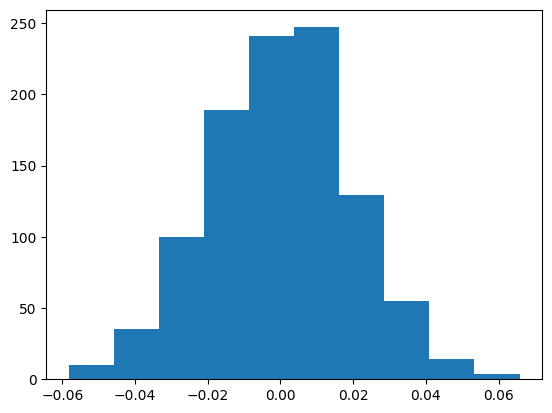

In [22]:
import matplotlib.pyplot as plt

plt.hist(x[1].detach().numpy())

In [12]:
from transformers import DebertaV2Config, DebertaV2ForSequenceClassification

config = DebertaV2Config(
    vocab_size=50265,
    hidden_size=1024,  
    num_hidden_layers=24, 
    num_attention_heads=16,  
    intermediate_size=4096, 
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,  
    max_position_embeddings=512,  
    num_labels=1 
)

model = DebertaV2ForSequenceClassification(config)

In [15]:
for x in model.parameters():
    print(x)
    break

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0062, -0.0027,  0.0407,  ...,  0.0082,  0.0234,  0.0230],
        [ 0.0059,  0.0092,  0.0018,  ...,  0.0167,  0.0238, -0.0246],
        ...,
        [-0.0213,  0.0036, -0.0148,  ...,  0.0348, -0.0047, -0.0048],
        [ 0.0017,  0.0295,  0.0041,  ...,  0.0368, -0.0217,  0.0081],
        [ 0.0166,  0.0071,  0.0162,  ..., -0.0041,  0.0122, -0.0135]],
       requires_grad=True)


In [8]:
for x in model.parameters():
    print(x)
    break

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0009, -0.0084, -0.0066,  ..., -0.0246, -0.0026,  0.0105],
        [ 0.0206, -0.0222, -0.0371,  ..., -0.0195, -0.0020,  0.0002],
        ...,
        [-0.0033,  0.0029,  0.0011,  ..., -0.0144, -0.0105, -0.0093],
        [-0.0034,  0.0048,  0.0181,  ..., -0.0046, -0.0012,  0.0095],
        [ 0.0014, -0.0200,  0.0061,  ...,  0.0116,  0.0065,  0.0126]],
       requires_grad=True)


In [7]:
import torch.nn as nn
for layer in model.modules():
    if isinstance(layer, (nn.Linear, nn.Conv2d)):
        layer.reset_parameters()

In [13]:
for x in model.parameters():
    print(x)
    break

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0559, -0.0171, -0.0196,  ...,  0.0035, -0.0144,  0.0009],
        [-0.0011, -0.0214,  0.0100,  ...,  0.0022, -0.0129, -0.0379],
        ...,
        [-0.0237, -0.0113, -0.0145,  ..., -0.0184,  0.0649, -0.0160],
        [-0.0212,  0.0064,  0.0005,  ...,  0.0097, -0.0330, -0.0540],
        [-0.0481, -0.0020, -0.0056,  ...,  0.0354, -0.0093,  0.0429]],
       device='cuda:0', requires_grad=True)


In [12]:
import math
for layer in model.modules():
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_uniform_(layer.weight, a=math.sqrt(5))
        if layer.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(layer.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(layer.bias, -bound, bound)
    elif isinstance(layer, nn.Conv2d):
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0)
    elif isinstance(layer, nn.Embedding):
        nn.init.normal_(layer.weight, mean=0, std=layer.embedding_dim ** -0.5)
        if layer.padding_idx is not None:
            nn.init.constant_(layer.weight[layer.padding_idx], 0)

(array([   0.,    0.,    0.,    0.,    0., 1024.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

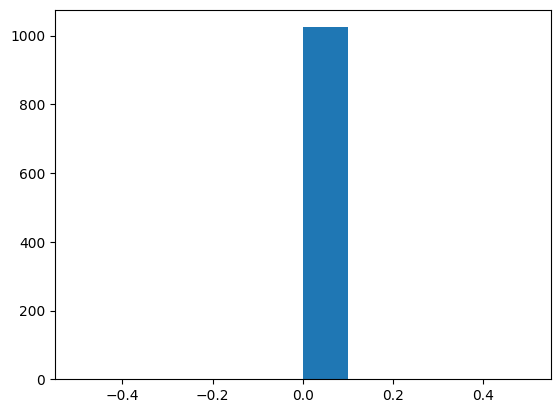

In [25]:
import matplotlib.pyplot as plt

plt.hist(x[0].detach().numpy())

In [35]:
dataset = pd.read_csv("src/data/titles_to_categories.csv")

In [36]:
dataset = pd.read_csv("src/data/titles_to_categories.csv")
target_categories = [
    "Sports & Outdoors",
    "Baby",
    "Men's Shoes",
    "Women's Handbags",
    "Women's Shoes",
    "Handmade Jewellery",
    "Men's Watches",
    "Boys"
]

filtered_dataset = dataset[dataset['category_name'].isin(target_categories)]

filtered_dataset['target'] = filtered_dataset['category_name'].apply(
    lambda x: 1 if x == "Sports & Outdoors" else 0
)

dataset = filtered_dataset

/tmp/ipykernel_3190855/149341752.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset['target'] = filtered_dataset['category_name'].apply(


In [40]:
filtered_dataset

,title,category_name,target
40639,Men's Original Two-Tone Memory Foam Slipper,Men's Shoes,0
40640,mens Ansa Fix Slide Sandal,Men's Shoes,0
40641,Body Glide Foot Anti Blister Balm (for Candian...,Men's Shoes,0
40642,Slippers for Women Men Cozy Memory Foam Plush ...,Men's Shoes,0
40643,"squish Shoe Covers Disposable Non Slip, 100 Pa...",Men's Shoes,0
...,...,...,...
5249804,Women's Slingback Low Heels Closed Toe Chunky ...,Women's Shoes,0
5249805,Women's Textured Knit Clog Slipper,Women's Shoes,0
5249806,Women's Arlon Heeled Sandal,Women's Shoes,0
5249807,Women's Roaming Multi Strap Sandals,Women's Shoes,0


[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15


In [6]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from peft import get_peft_model, LoraConfig

# Загрузка модели
model_name = "microsoft/deberta-v3-xsmall"
config = AutoConfig.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

# Настройка LoRA
lora_config = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.01, bias="none", inference_mode=False)
model = get_peft_model(model, lora_config)

# Функция для подсчета обучаемых и необучаемых параметров
def count_parameters(model):
    trainable_params = 0
    non_trainable_params = 0
    for param in model.parameters():
        if param.requires_grad:
            trainable_params += param.numel()
        else:
            non_trainable_params += param.numel()
    return trainable_params, non_trainable_params

# Подсчет параметров
trainable_params, non_trainable_params = count_parameters(model)

print(f"Обучаемых параметров: {trainable_params}")
print(f"Необучаемых параметров: {non_trainable_params}")


/home/jovyan/.local/share/virtualenvs/ptls-experiments-w-dEu3oS/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

/home/jovyan/.local/share/virtualenvs/ptls-experiments-w-dEu3oS/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Обучаемых параметров: 147456
Необучаемых параметров: 70830722
